# Previsão de Deputados Eleitos

- 1 Há desbalanceamento das classes (isto é, uma classe tem muito mais instâncias que outra)? 
    Em que proporção? 
    Quais efeitos colaterais o desbalanceamento de classes pode causar no classificador? 
    Como você poderia tratar isso? (2 pt.)

- 2 Treine: um modelo de regressão logística, KNN, uma árvore de decisão e um modelo de adaboost. Tune esses     modelos usando validação cruzada e controle overfitting se necessário, considerando as particularidades de cada modelo.  (2 pts.)
    
- 3 Reporte Precision, Recall e AUC-Precision&Recall no treino e validação. Há uma grande diferença de desempenho no treino/validação? Como você avalia os resultados? Justifique sua resposta. (2 pt.)
    
- 4 Interprete as saídas dos modelos. 
    Quais atributos parecem ser mais importantes de acordo com cada modelo? (2 pts.)
    
- 5 Envie seus melhores modelos à competição do Kaggle. 
    Faça pelo menos uma submissão. 
    Sugestões para melhorar o modelo: (2 pts.)
        
    - 5.1 Experimente outros modelos (e.g. SVM, RandomForests e GradientBoosting).
    - 5.2 Experimente outras estratégias de ensembles (e.g. Stacking).
    - 5.3 Experimente balancear as classes,  caso estejam desbalanceadas

In [67]:
%matplotlib inline

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.style.use('seaborn-whitegrid')

In [68]:
def normalizando_dados(dataframe):
    
    numeric_features = dataframe.dtypes[dataframe.dtypes != "object"].index

    skewed_features = dataframe[numeric_features].apply(lambda x: x.dropna().skew())

    skewed_features = skewed_features[skewed_features > 0.75]

    skewed_features = skewed_features.index

    dataframe[skewed_features] = np.log1p(dataframe[skewed_features])

    dataframe = pd.get_dummies(dataframe)

    dataframe = dataframe.fillna(dataframe.mean())
    
    return dataframe

### Importando dados de treino e de teste

In [101]:
train = pd.read_csv('../datasets/train.csv')
test = pd.read_csv('../datasets/test.csv')

In [103]:
train.shape

(7622, 24)

In [104]:
test.shape

(4592, 23)

In [112]:
train['ano'] = train['ano'].astype(object)
train.dtypes

ano                                       object
sequencial_candidato                       int64
nome                                      object
uf                                        object
partido                                   object
quantidade_doacoes                         int64
quantidade_doadores                        int64
total_receita                            float64
media_receita                            float64
recursos_de_outros_candidatos.comites    float64
recursos_de_pessoas_fisicas              float64
recursos_de_pessoas_juridicas            float64
recursos_proprios                        float64
recursos_de_partido_politico             float64
quantidade_despesas                        int64
quantidade_fornecedores                    int64
total_despesa                            float64
media_despesa                            float64
cargo                                     object
sexo                                      object
grau                

In [113]:
test['ano'] = test['ano'].astype(object)
test.dtypes

ano                                       object
sequencial_candidato                       int64
nome                                      object
uf                                        object
partido                                   object
quantidade_doacoes                         int64
quantidade_doadores                        int64
total_receita                            float64
media_receita                            float64
recursos_de_outros_candidatos.comites    float64
recursos_de_pessoas_fisicas              float64
recursos_de_pessoas_juridicas            float64
recursos_proprios                        float64
recursos_de_partido_politico             float64
quantidade_despesas                        int64
quantidade_fornecedores                    int64
total_despesa                            float64
media_despesa                            float64
cargo                                     object
sexo                                      object
grau                

## Analisando os dados

#### Verificando correlação entre as features

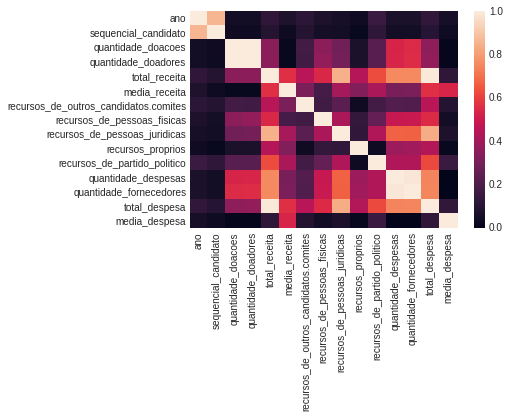

In [81]:
corr = train.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

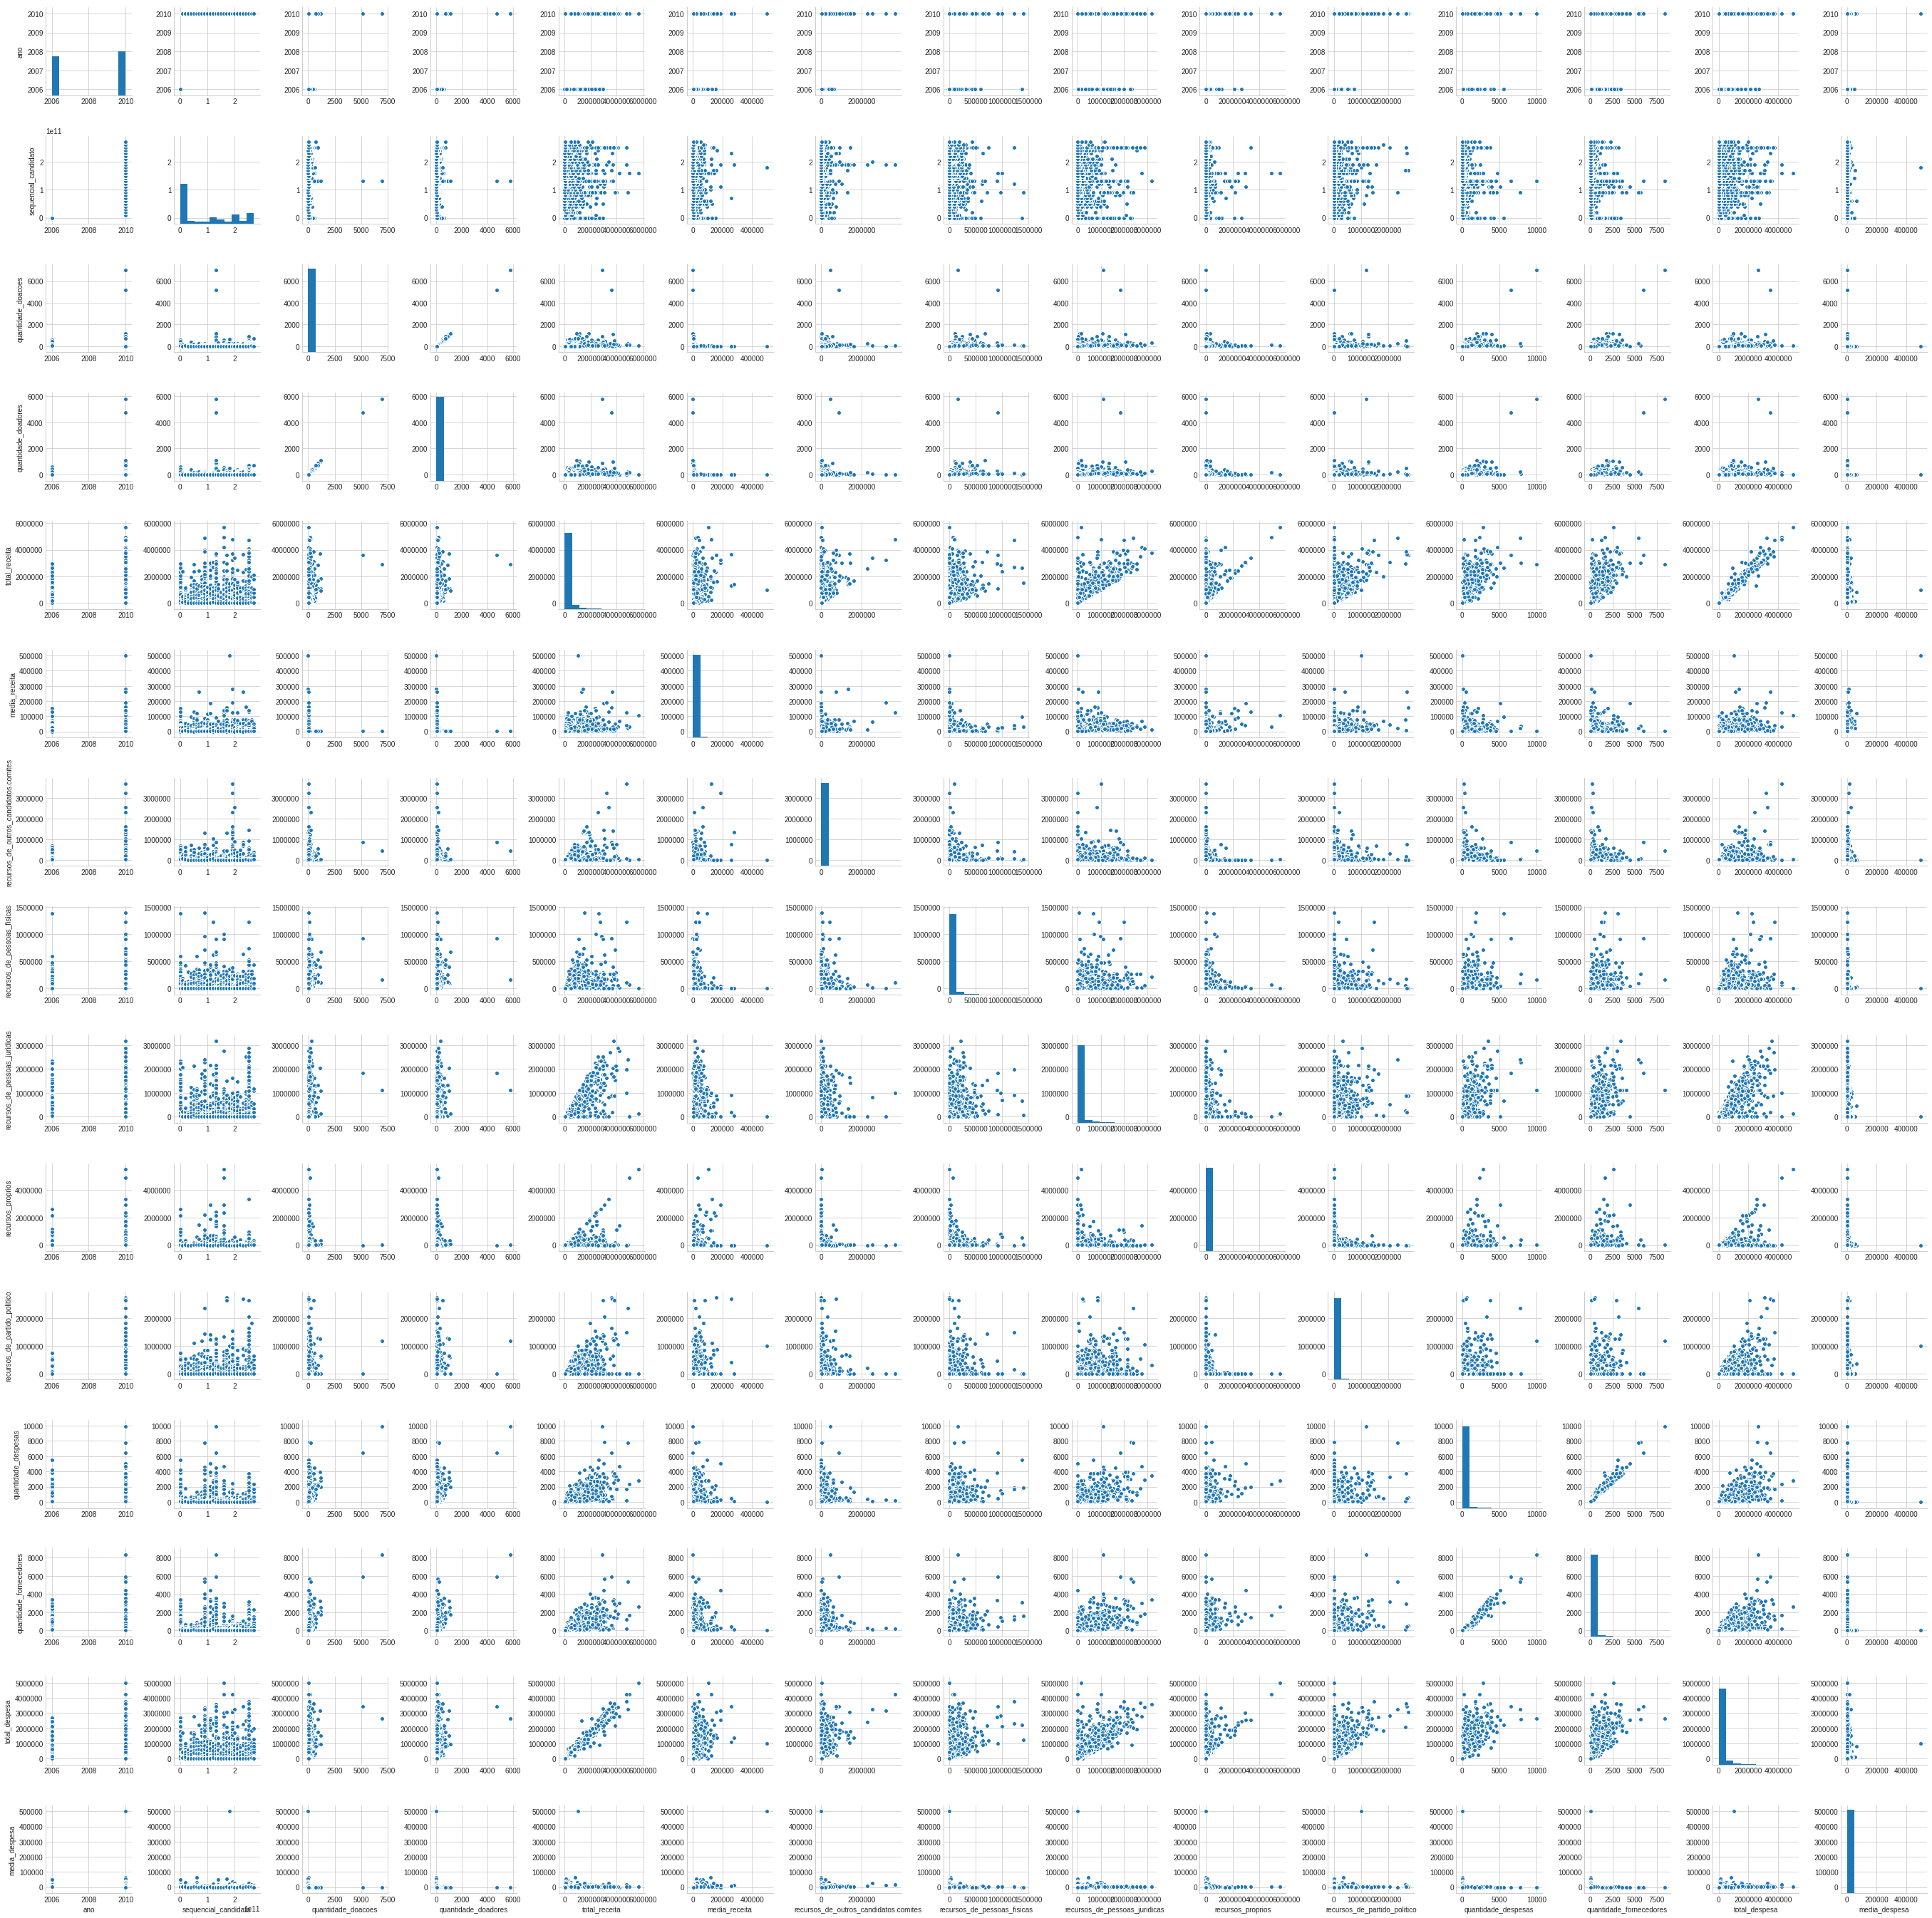

In [7]:
sns.pairplot(train)

In [107]:
train.groupby('cargo').size().reset_index(name='qtd').sort_values('qtd', ascending=False)

,cargo,qtd
0,DEPUTADO FEDERAL,7622


In [108]:
test.groupby('cargo').size().reset_index(name='qtd').sort_values('qtd', ascending=False)

,cargo,qtd
0,DEPUTADO FEDERAL,4592


In [ ]:
train.groupby('ocupacao').size().reset_index(name='qtd').sort_values('qtd', ascending=False)

In [ ]:
test.groupby('ocupacao').size().reset_index(name='qtd').sort_values('qtd', ascending=False)

In [114]:
train.groupby('ano').size().reset_index(name='qtd').sort_values('qtd', ascending=False)

,ano,qtd
1,2010,4041
0,2006,3581


In [115]:
test.groupby('ano').size().reset_index(name='qtd').sort_values('qtd', ascending=False)

,ano,qtd
0,2014,4592


## 1 - Há desbalanceamento das classes? 
- Isto é, uma classe tem muito mais instâncias que outra? 


In [87]:
group_situacao = train.groupby('situacao').size().reset_index(name='qtd').sort_values('qtd', ascending=False)
group_situacao

,situacao,qtd
1,nao_eleito,6596
0,eleito,1026


Sim. A quantidade de exemplos na classe dos candidatos **não eleitos** é aproximadamente 6 vezes maior do que a quantidade de exemplos na classe de candidatos **eleitos**.

- **Em que proporção?** 

In [88]:
group_situacao['proporcao'] = group_situacao['qtd'] / sum(group_situacao['qtd'])
group_situacao['porcentagem'] = (group_situacao['qtd'] / sum(group_situacao['qtd']))*100

group_situacao.style.format({
    'porcentagem': '{:.2f}%'
})

,situacao,qtd,proporcao,porcentagem
1,nao_eleito,6596,0.86539,86.54%
0,eleito,1026,0.13461,13.46%


A proporção do desbalanceamento é
- Classe não eleito - 0,87
- Classe eleito - 0,13

- **Quais efeitos colaterais o desbalanceamento de classes pode causar no classificador?**

Overfitting dos dados para a classe com maior quantidade de exemplos, gerando assim um classificador com tendência a classificar os candidatos como **não eleitos**

# Preparando dados para a classificação

In [116]:
y_train = train['situacao']
train = train.drop('situacao', axis=1)
train.shape

(7622, 23)

In [160]:
y_train = y_train.replace('nao_eleito', 0)
y_train.head()

0         0
1         0
2    eleito
3         0
4    eleito
Name: situacao, dtype: object

In [161]:
y_train = y_train.replace('eleito', 1)
y_train.head()

0    0
1    0
2    1
3    0
4    1
Name: situacao, dtype: int64

In [117]:
test.shape

(4592, 23)

**OBS:** Fazendo merge no conjunto de dados para que ao executar o pd.get_dummies eles fique com a mesma quantidade de colunas,
depois para o treinamento e teste os dados serão separados

In [126]:
all_data = train.append(test, ignore_index=True)
all_data.shape

(12214, 23)

In [127]:
all_data = all_data.drop(['media_receita', 'media_despesa', 'cargo'], axis=1)
all_data = normalizando_dados(all_data)
all_data.shape

(12214, 11176)

In [132]:
all_data.groupby(['ano_2014', 'ano_2006', 'ano_2010']).size().reset_index(name='qtd').sort_values('qtd', ascending=False)

,ano_2014,ano_2006,ano_2010,qtd
2,1,0,0,4592
0,0,0,1,4041
1,0,1,0,3581


In [137]:
test = all_data.loc[all_data['ano_2014'] == 1]
test.shape

(4592, 11176)

In [139]:
train = all_data.loc[all_data['ano_2014'] != 1]
train.shape

(7622, 11176)

In [140]:
x_train = train
x_train.shape

(7622, 11176)

## 2 - Treinando Modelos de Classificação

#### Funções comuns para validação cruzada e visualização do resíduo

In [156]:
from sklearn.model_selection import cross_val_score

In [157]:
def evaluation_model(model, cv, metric):
    metric_evaluation = np.sqrt(-cross_val_score(model, x_train, y_train, scoring=metric, cv=cv))
    print("{0} is: {1} ".format(scoring, rmse))
    return metric_evaluation

In [154]:
def gerar_vis_validacao(measures, alphas, title_measure):
    matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)
    data = pd.Series(measures, index=alphas)
    data.plot(title = "Validação")
    plt.xlabel("alpha")
    plt.ylabel(title_measure)

### Regressão Logística

In [152]:
rmse = 'neg_mean_squared_error'
r2 = 'r2'

In [142]:
model_rl = LogisticRegression(C = 0.7, random_state=42)
model_rl.fit(x_train, y_train)

LogisticRegression(C=0.7, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [158]:
cv = 5
rmse_rl = evaluation_model(LogisticRegression(C = 0.7, random_state=42), cv, rmse).mean() 

rmse_rl

ValueError: could not convert string to float: 'nao_eleito'

### Árvore de Decisão

In [143]:
from sklearn.ensemble import RandomForestClassifier

In [144]:
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

### KNN

### Adaboost

## 3 - Avaliando os Modelos: Acurácia, Precision, Recall e F-Measure

In [145]:
from sklearn import metrics

In [150]:
def calc_metricas(pred_model):
    model_acuracia = metrics.accuracy_score(test, pred_model)
    model_precisao = metrics.precision_score(test, pred_model)
    model_recall = metrics.recall_score(test, pred_model)
    model_fmeasure = metrics.f1_score(test, pred_model)
    
    print("Acurácia: {0} \n \
           Precisão: {1} \n \
           Recall: {2} \n \
           F-Measure: {3}".format(model_acuracia, model_precisao, model_recall, model_fmeasure))

### Regressão Logística

In [151]:
pred_model_rl = model_rl.predict(test)
calc_metricas(pred_model_rl)

ValueError: Classification metrics can't handle a mix of continuous-multioutput and binary targets

### KNN

In [ ]:
pred_model_knn = model_knn.predict(test)
calc_metricas(pred_model_knn)

### Árvore de Decisão

In [70]:
pred_model_rf = model_rf.predict(test)
calc_metricas(pred_model_rf)

ValueError: Number of features of the model must match the input. Model n_features is 7297 and input n_features is 4808 

### Adaboost

In [ ]:
pred_model_ada = model_ada.predict(test)
calc_metricas(pred_model_ada)